In [43]:
#%matplotlib inline
import random
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim 
import torch.utils.data
import torchvision.utils as vutils
import torch
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision
import matplotlib.pyplot as plt

# Set random seed for reproducibility
manualSeed = 12
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

os.environ['KMP_DUPLICATE_LIB_OK']='True'

Random Seed:  12


In [57]:
# Number of workers for dataloader
workers = 8

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 150

# Learning rate for optimizers
lr = 0.0001

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [58]:
from torch.utils.data import ConcatDataset

transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.Flowers102(root='./data', split='test', transform=transform, download=True)
testset = torchvision.datasets.Flowers102(root='./data', split='train', transform=transform, download=True)
validdataset = torchvision.datasets.Flowers102(root='./data', split='val', transform=transform, download=True)
dataset = ConcatDataset([trainset, testset, validdataset])

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

print("訓練集樣本數量:", len(dataset))

訓練集樣本數量: 8189


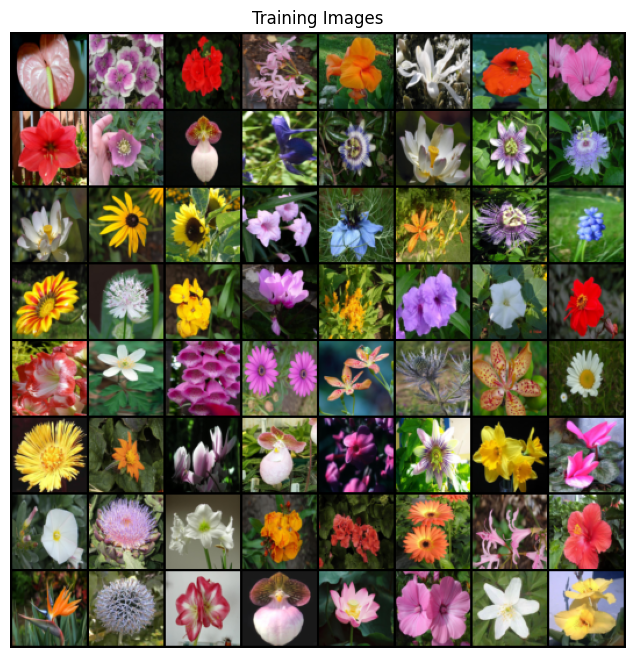

In [59]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

## Initialize parameters of Generator and Discriminator
This step for initializing the parameters of the generator and discriminator.
And define the structure of the dcGAN.

In [60]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

def weights_init_xavier(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.xavier_normal_(m.weight.data, gain=0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [61]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

In [62]:
class Critic(nn.Module):
    def __init__(self, ngpu):
        super(Critic, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            # nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [63]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

# Create the Discriminator
netC = Critic(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netC = nn.DataParallel(netC, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netC.apply(weights_init)

# Print the model
print(netC)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [64]:
# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.RMSprop(netC.parameters(), lr=lr)
optimizerG = optim.RMSprop(netG.parameters(), lr=lr)

clip_value = 0.01
n_critic = 5

## Training Step

In [65]:
# Training Loop
import torchvision.transforms as T
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
# masked_real_cpu = add_random_mask(real_cpu.clone())
print("Starting Training Loop...")

from itertools import cycle

# 將 dataloader 包裝成一個循環迭代器
dataloader_iter = cycle(dataloader)

# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
    # for i in range(len(dataloader)):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        for k in range(n_critic):
            netC.zero_grad()
            
            # Re-sample a new batch of real data for each critic update
            real_data = data[0].to(device)
            batch_size = real_data.size(0)

            # Compute loss with real data
            real_output = netC(real_data)
            loss_real = -torch.mean(real_output)

            # Generate fake data
            noise = torch.randn(batch_size, nz, 1, 1, device=device)
            fake_data = netG(noise)
            fake_output = netC(fake_data.detach())
            loss_fake = torch.mean(fake_output)

            # Compute total loss and update D
            errC = loss_real + loss_fake
            errC.backward()
            optimizerD.step()

            # Clamp parameters to enforce Lipschitz constraint
            for p in netC.parameters():
                p.data.clamp_(-clip_value, clip_value)

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake_data = netG(noise)
        fake_output = netC(fake_data)
        errG = -torch.mean(fake_output)
        errG.backward()
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_C: %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errC.item(), errG.item()))

        # Save Losses for plotting laterå
        G_losses.append(errG.item())
        D_losses.append(errC.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/150][0/64]	Loss_D: -0.0919	Loss_C: 0.0559
[0/150][50/64]	Loss_D: -1.0533	Loss_C: 0.5412
[1/150][0/64]	Loss_D: -1.1651	Loss_C: 0.5908
[1/150][50/64]	Loss_D: -1.2576	Loss_C: 0.6455
[2/150][0/64]	Loss_D: -1.1402	Loss_C: 0.6791
[2/150][50/64]	Loss_D: -1.0805	Loss_C: 0.5495
[3/150][0/64]	Loss_D: -1.1717	Loss_C: 0.6351
[3/150][50/64]	Loss_D: -1.2765	Loss_C: 0.6388
[4/150][0/64]	Loss_D: -1.2300	Loss_C: 0.6677
[4/150][50/64]	Loss_D: -1.3132	Loss_C: 0.6484
[5/150][0/64]	Loss_D: -0.0246	Loss_C: -0.6611
[5/150][50/64]	Loss_D: -1.2139	Loss_C: 0.6090
[6/150][0/64]	Loss_D: -1.1838	Loss_C: 0.6244
[6/150][50/64]	Loss_D: -1.1414	Loss_C: 0.6338
[7/150][0/64]	Loss_D: -1.1835	Loss_C: 0.6207
[7/150][50/64]	Loss_D: -1.0943	Loss_C: 0.6300
[8/150][0/64]	Loss_D: -1.2326	Loss_C: 0.6179
[8/150][50/64]	Loss_D: -1.1066	Loss_C: 0.6013
[9/150][0/64]	Loss_D: -1.1405	Loss_C: 0.5889
[9/150][50/64]	Loss_D: -0.9992	Loss_C: 0.6416
[10/150][0/64]	Loss_D: -1.2780	Loss_C: 0.6336
[10/150][50/64]	L

## Create fake dataset for calculating FID scores
FID scores use to evaluate the similarity between two datasets.

In [66]:
torch.save(netG.state_dict(), 'model_weight/Generator_weight.pth')
torch.save(netC.state_dict(), 'model_weight/Critic_weight.pth')

In [67]:
noise = torch.randn(8189, nz, 1, 1, device=device)
netG.eval()
with torch.no_grad():
    fake = netG(noise)

for j in range(fake.size(0)):
    transform = T.Compose([
        T.Normalize((-1, -1, -1), (2, 2, 2)),
        T.ToPILImage()
    ])
    img = transform(fake[j].cpu())
    img.save('./gen/' + str(j) + '.jpg')

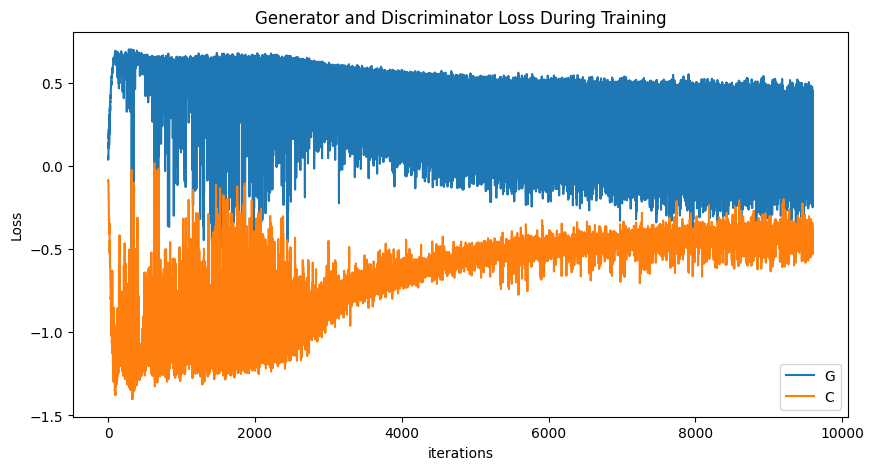

In [68]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="C")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [69]:
import torchvision
from pytorch_fid import fid_score

## The path of original dataset resized into 64x64 pixels.
resized_folder_path = './resized/'
## The path of generated dataset.
generated_images_folder = './gen/'
## Use Model Inception V3 to calculate FID score. (Inception V3 is a pre-trained model)
inception_model = torchvision.models.inception_v3(pretrained=True)
fid_value = fid_score.calculate_fid_given_paths([resized_folder_path, generated_images_folder], batch_size =batch_size, device=device , dims=2048, num_workers=8)
print('FID value:', fid_value)

100%|██████████| 66/66 [00:04<00:00, 13.66it/s]


FID value: 54.228466004442055


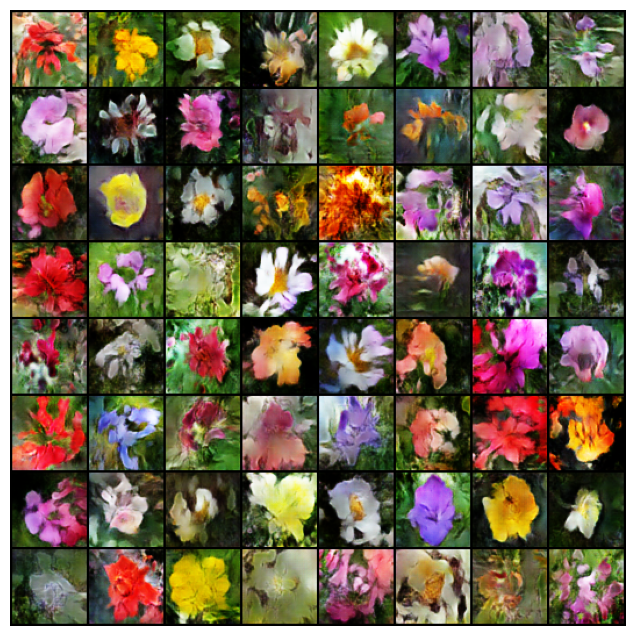

In [70]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]